
##Fake News Detection Engine

In [399]:
pip install wordcloud


In [400]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from wordcloud import WordCloud
import os

In [401]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score



In [402]:
fake = pd.read_csv("https://raw.githubusercontent.com/laxmimerit/fake-real-news-dataset/main/data/Fake.csv" )


## Explore Fake News File



In [404]:
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [405]:
fake.columns


Index(['title', 'text', 'subject', 'date'], dtype='object')

In [407]:
fake['subject'].value_counts()

News               9050
politics           6841
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: subject, dtype: int64

<Axes: xlabel='subject', ylabel='count'>

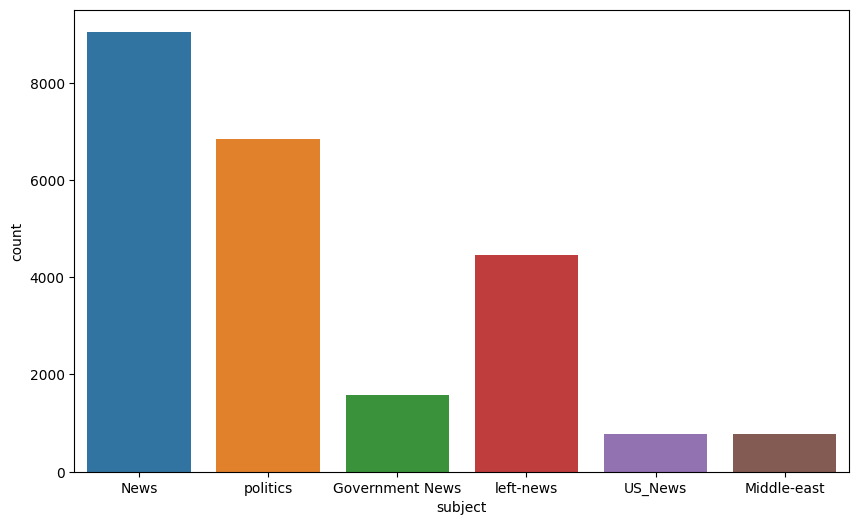

In [408]:
plt.figure(figsize=(10,6))
sns.countplot(x='subject',data=fake)

In [409]:
empty_cells = fake['text'].isnull() | (fake['text'] == '') | (fake['text'] == ' ')

# Display rows with empty cells in the 'text' column
rows_with_empty_text = fake[empty_cells]
print(rows_with_empty_text)


                                                   title text    subject  \
10923  TAKE OUR POLL: Who Do You Think President Trum...        politics   
11041  Joe Scarborough BERATES Mika Brzezinski Over “...        politics   
11190  WATCH TUCKER CARLSON Scorch Sanctuary City May...        politics   
11225  MAYOR OF SANCTUARY CITY: Trump Trying To Make ...        politics   
11236  SHOCKER: Public School Turns Computer Lab Into...        politics   
...                                                  ...  ...        ...   
21816  BALTIMORE BURNS: MARYLAND GOVERNOR BRINGS IN N...       left-news   
21826  FULL VIDEO: THE BLOCKBUSTER INVESTIGATION INTO...       left-news   
21827  (VIDEO) HILLARY CLINTON: RELIGIOUS BELIEFS MUS...       left-news   
21857  (VIDEO)ICE PROTECTING OBAMA: WON’T RELEASE NAM...       left-news   
21873  (VIDEO) HYSTERICAL SNL TAKE ON HILLARY’S ANNOU...       left-news   

               date  
10923  May 10, 2017  
11041  Apr 26, 2017  
11190   Apr 6, 2017  

## WordCloud

In [410]:

text = ' '.join(fake['text'].tolist())

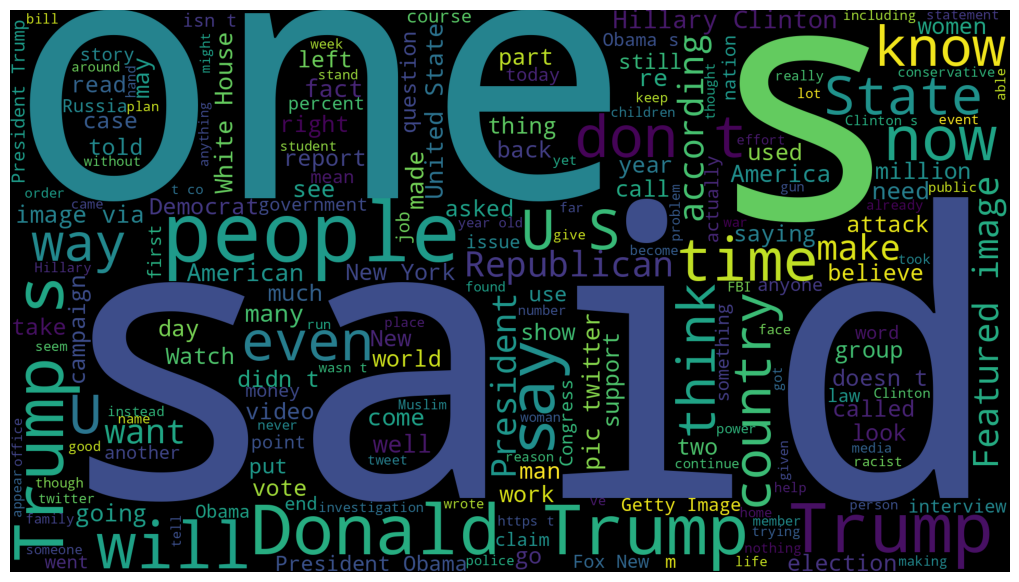

In [411]:
wordcloud = WordCloud(width=1920, height=1080).generate(text)

# Display the word cloud
fig = plt.figure(figsize=(10, 20))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

##Explore Real News File

In [431]:
real = pd.read_csv("https://raw.githubusercontent.com/laxmimerit/fake-real-news-dataset/main/data/True.csv" )

In [432]:
empty_cells = real['text'].isnull() | (real['text'] == '') | (real['text'] == ' ')

# Display rows with empty cells in the 'text' column
rows_with_empty_text = real[empty_cells]
print(rows_with_empty_text)

                               title text       subject            date
8970  Graphic: Supreme Court roundup       politicsNews  June 16, 2016 


In [433]:
text = ' '.join(real['text'].tolist())


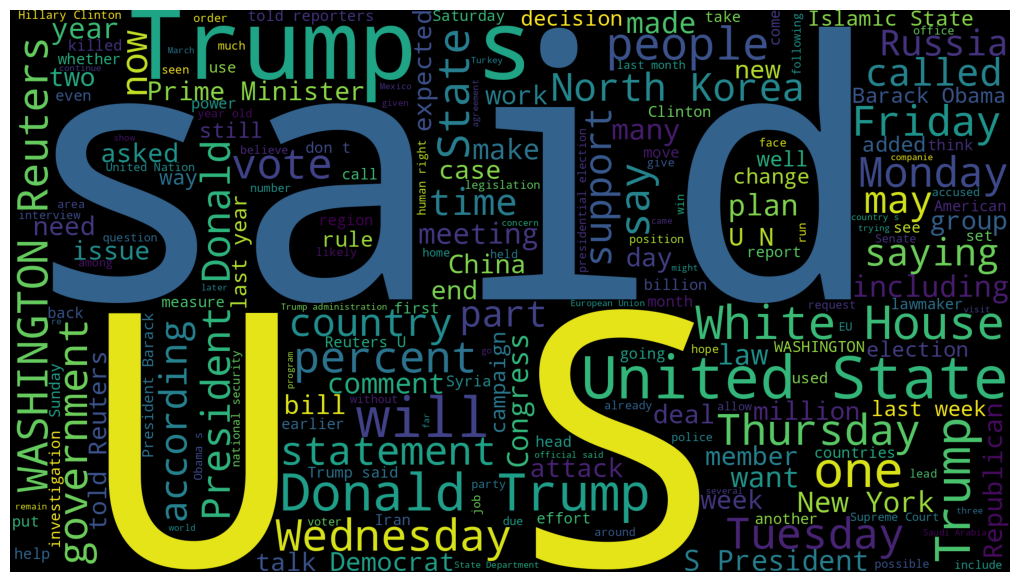

In [434]:
wordcloud = WordCloud(width=1920, height=1080).generate(text)

# Display the word cloud
fig = plt.figure(figsize=(10, 20))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

 **1. Real News has source of publication as opposed to Fake News**

 **2. Most of text contains reuters information such as "Washington (Reuters)"**

 **3. Some Texts are tweets**

 **4. Few Text lack publication text**


 ## **Cleaning Data**

In [435]:
real.sample(10)

,title,text,subject,date
3135,U.S. top court will not review Ohio 'perfect' ...,WASHINGTON (Reuters) - The U.S. Supreme Court ...,politicsNews,"June 19, 2017"
12083,Iran tells France's Macron not to 'blindly fol...,LONDON (Reuters) - Iran on Sunday criticized F...,worldnews,"December 17, 2017"
10081,Creditors sue to block Puerto Rico development...,SAN JUAN (Reuters) - Creditors of Puerto Rico’...,politicsNews,"April 4, 2016"
12371,Congo fighters jailed for life for child rape ...,"GOMA, Democratic Republic of Congo (Reuters) -...",worldnews,"December 13, 2017"
1464,White House cracks down on use of charter plan...,WASHINGTON (Reuters) - The White House on Frid...,politicsNews,"September 29, 2017"
10927,Lawyers see limited legal options for workers ...,(Reuters) - Employees of U.S. companies seekin...,politicsNews,"February 8, 2016"
16497,Islamic State claims deadly attack on Libyan c...,"BENGHAZI, Libya (Reuters) - Two soldiers were ...",worldnews,"October 25, 2017"
15265,Armed separatists occupy villages near Freepor...,"JAKARTA/TIMIKA, Indonesia (Reuters) - Armed se...",worldnews,"November 9, 2017"
10645,"Fight night: Rubio, Cruz gang up on Trump in d...",HOUSTON (Reuters) - U.S. Republican rivals Mar...,politicsNews,"February 25, 2016"
15491,Japan nuclear regulator says restart approval ...,TOKYO (Reuters) - The pace of approvals for nu...,worldnews,"November 7, 2017"


In [436]:
unknown_publishers = []
for index, row in enumerate(real.text.values):
  try:
    record =row.split("-", maxsplit=1)
    record[1]

    assert(len(record[0])<120)
  except:
    unknown_publishers.append(index)


In [437]:
len(unknown_publishers)

222

In [438]:
real.iloc[unknown_publishers].text

7        The following statements were posted to the ve...
8        The following statements were posted to the ve...
12       The following statements were posted to the ve...
13       The following statements were posted to the ve...
14        (In Dec. 25 story, in second paragraph, corre...
                               ...                        
20135     (Story corrects to million from billion in pa...
20500     (This Sept 8 story corrects headline, clarifi...
20667     (Story refiles to add dropped word  not , in ...
21246     (Story corrects third paragraph to show Mosul...
21339     (Story corrects to fix spelling in paragraph ...
Name: text, Length: 222, dtype: object

In [439]:
empty_cells = real['text'].isnull() | (real['text'] == '')
# Display rows with empty cells in the 'text' column
rows_with_empty_text = real[empty_cells]
print(rows_with_empty_text)

Empty DataFrame
Columns: [title, text, subject, date]
Index: []


In [440]:
real.iloc[8970]

title      Graphic: Supreme Court roundup
text                                     
subject                      politicsNews
date                       June 16, 2016 
Name: 8970, dtype: object

In [441]:
real = real.drop(index=8970)

In [430]:
real.iloc[8970]

title      Milestones in legal fight over Texas abortion law
text       (Reuters) - The U.S. Supreme Court is set to r...
subject                                         politicsNews
date                                          June 26, 2016 
Name: 8971, dtype: object

In [442]:
publisher = []
tmp_text = []

for index, row in enumerate(real.text.values):
    if index in unknown_publishers:
        tmp_text.append(row)
        publisher.append('Unknown')

    else:
        record = row.split('-', maxsplit=1)
        publisher.append(record[0].strip())
        tmp_text.append(record[1].strip())


In [443]:
real['publisher']=publisher
real['text'] = tmp_text

In [444]:
real.head(5)

,title,text,subject,date,publisher
0,"As U.S. budget fight looms, Republicans flip t...",The head of a conservative Republican faction ...,politicsNews,"December 31, 2017",WASHINGTON (Reuters)
1,U.S. military to accept transgender recruits o...,Transgender people will be allowed for the fir...,politicsNews,"December 29, 2017",WASHINGTON (Reuters)
2,Senior U.S. Republican senator: 'Let Mr. Muell...,The special counsel investigation of links bet...,politicsNews,"December 31, 2017",WASHINGTON (Reuters)
3,FBI Russia probe helped by Australian diplomat...,Trump campaign adviser George Papadopoulos tol...,politicsNews,"December 30, 2017",WASHINGTON (Reuters)
4,Trump wants Postal Service to charge 'much mor...,President Donald Trump called on the U.S. Post...,politicsNews,"December 29, 2017",SEATTLE/WASHINGTON (Reuters)


In [445]:
real.shape

(21416, 5)

In [446]:
empty_fake_index = [index for index, text in enumerate(fake.text.tolist()) if str(text).strip()==""]

In [447]:
fake.iloc[empty_fake_index]

,title,text,subject,date
10923,TAKE OUR POLL: Who Do You Think President Trum...,,politics,"May 10, 2017"
11041,Joe Scarborough BERATES Mika Brzezinski Over “...,,politics,"Apr 26, 2017"
11190,WATCH TUCKER CARLSON Scorch Sanctuary City May...,,politics,"Apr 6, 2017"
11225,MAYOR OF SANCTUARY CITY: Trump Trying To Make ...,,politics,"Apr 2, 2017"
11236,SHOCKER: Public School Turns Computer Lab Into...,,politics,"Apr 1, 2017"
...,...,...,...,...
21816,BALTIMORE BURNS: MARYLAND GOVERNOR BRINGS IN N...,,left-news,"Apr 27, 2015"
21826,FULL VIDEO: THE BLOCKBUSTER INVESTIGATION INTO...,,left-news,"Apr 25, 2015"
21827,(VIDEO) HILLARY CLINTON: RELIGIOUS BELIEFS MUS...,,left-news,"Apr 25, 2015"
21857,(VIDEO)ICE PROTECTING OBAMA: WON’T RELEASE NAM...,,left-news,"Apr 14, 2015"


In [448]:
real['text'] = real['title']+" "+ real['text']
fake['text'] = fake['title']+" "+ fake['text']

In [449]:
real['text'] = real['text'].apply(lambda x: str(x).lower())
fake['text'] = fake['text'].apply(lambda x: str(x).lower())

## Preprocessing Text

In [450]:
real["class"] = 1
fake["class"] = 0

In [451]:
real.columns

Index(['title', 'text', 'subject', 'date', 'publisher', 'class'], dtype='object')

In [452]:
real = real[['text', 'class']]

In [453]:
fake = fake[['text', 'class']]

In [454]:
data = real.append(fake, ignore_index=True)

<ipython-input-454-45d5ced910ac>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = real.append(fake, ignore_index=True)


In [455]:
data.shape

(44897, 2)

In [457]:
data.sample(10)

,text,class
38492,crazy! u.s. will pay to import mentally ill il...,0
33321,"boom! leaders of 34,000 black churches tell me...",0
19255,"magnitude 6.2 quake hits southeast of oaxaca, ...",1
478,white house does not expect u.s. government sh...,1
37576,breaking: a third democrat senator to vote for...,0
23241,eric trump accidentally exposes who was behin...,0
25374,senator asks doj to step in after white supre...,0
43086,sharpton shakes down pastors for donations at ...,0
24682,‘f*cking grow up’: the internet destroys trum...,0
10952,"in contentious debate, clinton and sanders bot...",1


In [459]:
!pip install spacy
!python -m spacy download en_core_web_sm
!pip install beautifulsoup4==4.9.1
!pip install textblob==0.15.3
!pip install git+https://github.com/laxmimerit/preprocess_kgptalkie.git --upgrade --force-reinstall

2023-12-31 22:05:40.637501: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-31 22:05:40.637561: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-31 22:05:40.639328: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-31 22:05:44.410467: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.6.0/en_core_web_sm-3.6.0-py3-none-any.whl (12.8 MB)
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_s

In [460]:
import preprocess_kgptalkie as ps

In [461]:
data['text'] = data['text'].apply(lambda x: ps.remove_special_chars(x))

In [462]:
data.iloc[34898]


text     its official this state puts donald trump over...
class                                                    0
Name: 34898, dtype: object

In [463]:
data.head()

,text,class
0,as us budget fight looms republicans flip thei...,1
1,us military to accept transgender recruits on ...,1
2,senior us republican senator let mr mueller do...,1
3,fbi russia probe helped by australian diplomat...,1
4,trump wants postal service to charge much more...,1


## Word To Vector Vectorization

In [464]:
!pip install --upgrade gensim
import gensim

In [465]:
y = data['class'].values

In [466]:
X = [d.split() for d in data['text'].tolist()]

In [467]:
print(X[0])

['as', 'us', 'budget', 'fight', 'looms', 'republicans', 'flip', 'their', 'fiscal', 'script', 'the', 'head', 'of', 'a', 'conservative', 'republican', 'faction', 'in', 'the', 'us', 'congress', 'who', 'voted', 'this', 'month', 'for', 'a', 'huge', 'expansion', 'of', 'the', 'national', 'debt', 'to', 'pay', 'for', 'tax', 'cuts', 'called', 'himself', 'a', 'fiscal', 'conservative', 'on', 'sunday', 'and', 'urged', 'budget', 'restraint', 'in', '2018', 'in', 'keeping', 'with', 'a', 'sharp', 'pivot', 'under', 'way', 'among', 'republicans', 'us', 'representative', 'mark', 'meadows', 'speaking', 'on', 'cbs', 'face', 'the', 'nation', 'drew', 'a', 'hard', 'line', 'on', 'federal', 'spending', 'which', 'lawmakers', 'are', 'bracing', 'to', 'do', 'battle', 'over', 'in', 'january', 'when', 'they', 'return', 'from', 'the', 'holidays', 'on', 'wednesday', 'lawmakers', 'will', 'begin', 'trying', 'to', 'pass', 'a', 'federal', 'budget', 'in', 'a', 'fight', 'likely', 'to', 'be', 'linked', 'to', 'other', 'issues',

In [468]:
DIM = 100
w2v_model = gensim.models.Word2Vec(sentences=X, vector_size=DIM, window=10, min_count=1)

In [469]:
vocab_length = len(w2v_model.wv.key_to_index)
print(vocab_length)


231872


In [470]:
w2v_model.wv['kenya']

array([-1.23162   , -2.5091307 , -1.7494178 ,  1.1564566 , -0.76479644,
       -1.399928  ,  0.97998345,  0.37808532, -1.8836697 ,  0.49824136,
        1.4387103 , -1.4101539 ,  0.11851704,  0.31829467, -0.5086665 ,
        0.04669648, -0.3754168 , -0.7532134 , -0.58859706, -1.2568003 ,
       -1.2951056 ,  1.6417238 ,  0.6548373 ,  0.73896366,  0.91090935,
       -1.2504706 , -0.5125622 ,  0.9909655 , -0.5814047 ,  0.0853477 ,
       -0.15629233, -0.77330995,  0.57606375,  0.8673206 ,  1.0580865 ,
        0.10296652, -0.9011766 , -0.14838484,  1.6025393 ,  1.1868831 ,
       -0.52846766, -0.2844821 , -0.7533735 ,  0.22038217,  1.7326076 ,
        0.28032646, -0.93828964,  1.5243222 ,  0.59270966, -1.0675946 ,
       -0.3139706 , -1.6577744 , -0.08473342, -1.1069487 , -1.0485393 ,
       -0.9063816 ,  0.966772  , -0.6674641 ,  2.3192053 , -0.07701164,
       -0.78400075, -0.49219173,  0.49317154,  0.12207532,  0.5813212 ,
        0.31835863,  0.66488564, -0.02373909,  0.04097899,  1.44

In [471]:
similar_words = w2v_model.wv.most_similar('kenya')

In [472]:
similar_words

[('honduras', 0.6336575746536255),
 ('kenyan', 0.6197471022605896),
 ('honduran', 0.6175194978713989),
 ('nairobi', 0.5888438820838928),
 ('uganda', 0.581668496131897),
 ('ivory', 0.5780653953552246),
 ('bolivia', 0.5778656005859375),
 ('cameroon', 0.570910632610321),
 ('guatemala', 0.5638901591300964),
 ('burundi', 0.5506299734115601)]

In [473]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

In [474]:
X = tokenizer.texts_to_sequences(X)

In [475]:
##tokenizer.word_index

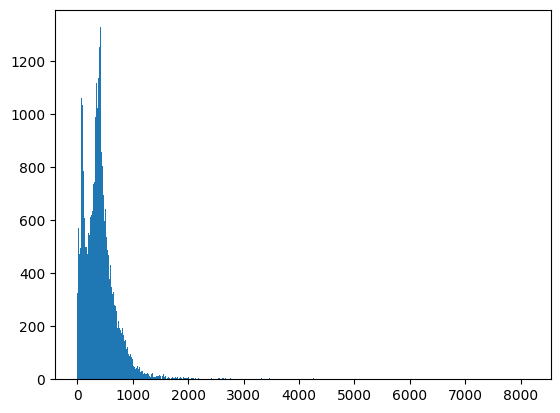

In [476]:
plt.hist([len(x) for x in X], bins = 700)
plt.show()

In [477]:
nos = np.array([len(x) for x in X])
len(nos[nos>1000])

1581

In [478]:
maxlen = 1000
X = pad_sequences(X, maxlen=maxlen)

In [479]:
len(X[130])

1000

In [480]:
vocab_size = len(tokenizer.word_index) + 1
vocab = tokenizer.word_index

In [481]:
def get_weight_matrix(model):
  weight_matrix = np.zeros((vocab_size, DIM))

  for word, i in vocab.items():
    weight_matrix[i] = model.wv[word]

    return weight_matrix

In [482]:
embedding_vectors = get_weight_matrix(w2v_model)

In [483]:
embedding_vectors.shape

(231873, 100)

In [484]:
model = Sequential()
model.add(Embedding(vocab_size, output_dim=DIM, weights = [embedding_vectors], input_length=maxlen, trainable=False))
model.add(LSTM(units=256))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [485]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 1000, 100)         23187300  
                                                                 
 lstm_10 (LSTM)              (None, 256)               365568    
                                                                 
 dense_10 (Dense)            (None, 1)                 257       
                                                                 
Total params: 23553125 (89.85 MB)
Trainable params: 365825 (1.40 MB)
Non-trainable params: 23187300 (88.45 MB)
_________________________________________________________________


In [486]:
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [487]:
model.fit(X_train, y_train, validation_split=0.3, epochs=25)

Epoch 1/25
737/737 [==============================] - 42s 55ms/step - loss: 0.6627 - acc: 0.5931 - val_loss: 0.6642 - val_acc: 0.5853
Epoch 2/25
737/737 [==============================] - 45s 62ms/step - loss: 0.6592 - acc: 0.5952 - val_loss: 0.6581 - val_acc: 0.5952
Epoch 3/25
737/737 [==============================] - 42s 58ms/step - loss: 0.6559 - acc: 0.6011 - val_loss: 0.6580 - val_acc: 0.5949
Epoch 4/25
737/737 [==============================] - 42s 58ms/step - loss: 0.6581 - acc: 0.5983 - val_loss: 0.6626 - val_acc: 0.5883
Epoch 5/25
737/737 [==============================] - 43s 58ms/step - loss: 0.6659 - acc: 0.5816 - val_loss: 0.6744 - val_acc: 0.5865
Epoch 6/25
737/737 [==============================] - 42s 57ms/step - loss: 0.6665 - acc: 0.5857 - val_loss: 0.6623 - val_acc: 0.5873
Epoch 7/25
737/737 [==============================] - 42s 57ms/step - loss: 0.6592 - acc: 0.5885 - val_loss: 0.6646 - val_acc: 0.5839
Epoch 8/25
737/737 [==============================] - 42s 57ms

In [488]:
y_pred = (model.predict(X_test) >=0.5).astype(int)

351/351 [==============================] - 7s 20ms/step


In [489]:
accuracy_score(y_test, y_pred)

0.6320712694877506

In [490]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.60      0.91      0.72      5922
           1       0.77      0.32      0.45      5303

    accuracy                           0.63     11225
   macro avg       0.68      0.62      0.59     11225
weighted avg       0.68      0.63      0.59     11225



In [494]:
x = ['''
‘New York Times’ Invents Entirely New Numerical System To Avoid Reporting Gazan Death Toll''']

In [495]:
x = tokenizer.texts_to_sequences(x)
x = pad_sequences(x, maxlen=maxlen)

In [496]:
(model.predict(x) >=0.5).astype(int)

1/1 [==============================] - 0s 35ms/step


array([[0]])

In [ ]:
!pip install faker
import faker
import random

fake_generator = faker.Faker()

# Function to generate fake news paragraphs
def generate_fake_news_paragraphs(num_paragraphs):
    fake_paragraphs = [fake_generator.paragraph() for _ in range(num_paragraphs)]
    return fake_paragraphs

# Generate 10 fake news paragraphs
fake_news_paragraphs = generate_fake_news_paragraphs(10)

# Sample true news paragraphs (modify as needed)
true_news_paragraphs = [
    "In a groundbreaking discovery, scientists have found a new species of marine life in the depths of the ocean.",
    "The stock market experienced a significant surge today, reaching record highs across multiple sectors.",
    "A new study reveals that regular exercise can have positive effects on mental health and cognitive function.",
    "World leaders convened at the summit to discuss pressing global issues and collaborate on solutions.",
    "The latest technology innovation promises to revolutionize the way we live, with potential applications in healthcare and communication.",
    "After years of negotiations, the two countries have reached a historic agreement to promote economic cooperation.",
    "In a heartwarming story, a community came together to support those in need during challenging times.",
    "Renowned author releases a highly anticipated novel that quickly becomes a bestseller worldwide.",
    "The international space mission successfully landed on Mars, marking a significant milestone in space exploration.",
    "Experts predict a positive outlook for the economy, citing improving indicators and market trends."
]

# Display the generated paragraphs
print("Fake News Paragraphs:")
for i, paragraph in enumerate(fake_news_paragraphs, 1):
    print(f"{i}. {paragraph}")

print("\nTrue News Paragraphs:")
for i, paragraph in enumerate(true_news_paragraphs, 1):
    print(f"{i}. {paragraph}")


Fake News Paragraphs:
1. Example factor out hard play edge. Suddenly image fight. Believe her ago administration especially. I nor vote prevent as.
2. Arm position base contain.
3. Artist own top director put pretty. Form pressure growth evening report change. Meet hit why.
4. Peace ability actually. Range win green star eye woman. Book enjoy animal.
5. Among strong really. Bar watch spring consider him source authority. Evening leave success because.
6. Hit design fine plant prevent need. Oil pay themselves view. Travel ten win serious Democrat miss.
7. Beyond practice trial the.
8. Generation through organization team national tend. Rock beyond event attention meeting part across.
9. Major officer radio red window carry. Various reveal themselves the interest garden tell along.
10. Physical hour to provide food eat through. During through blue near past choose right TV.

True News Paragraphs:
1. In a groundbreaking discovery, scientists have found a new species of marine life in the 